dataset link : https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = 'dataset/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_scc', 'lung_n']

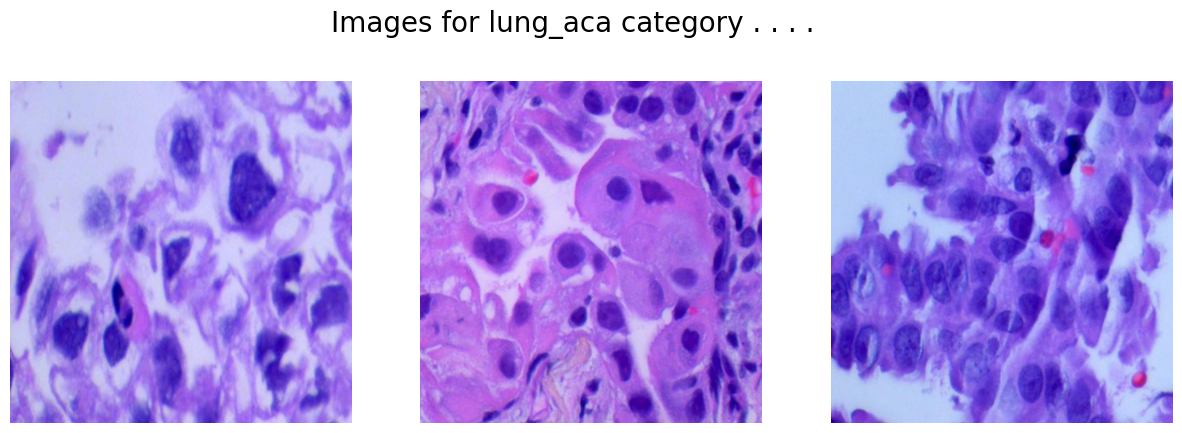

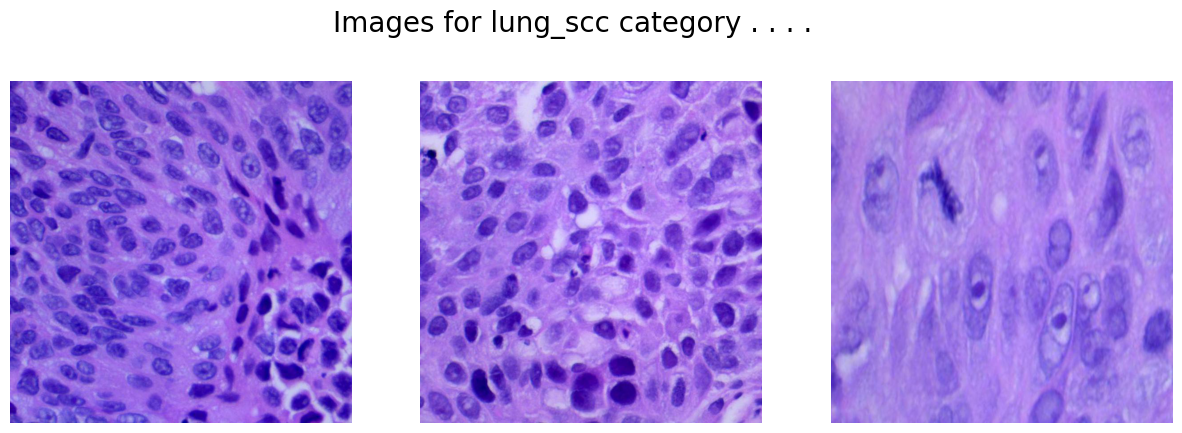

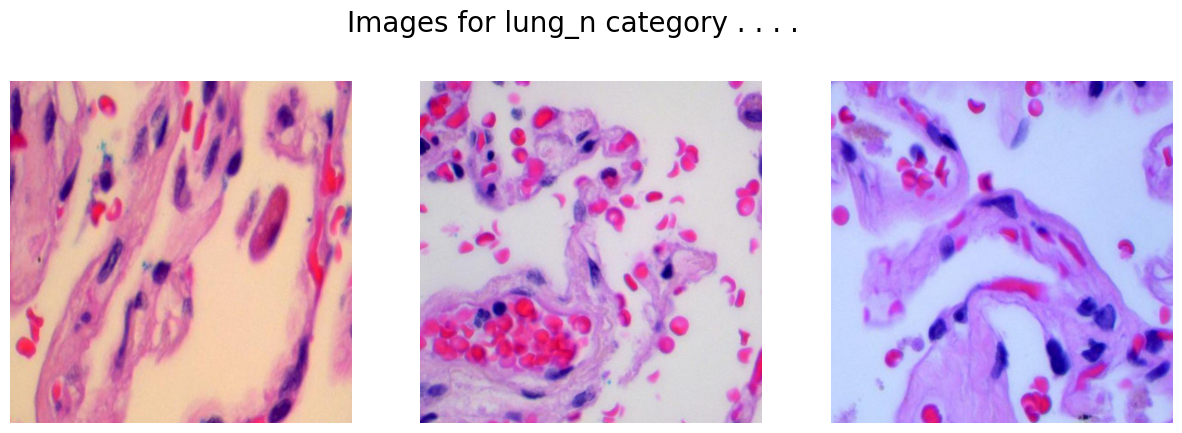

In [7]:

path = 'dataset/lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [8]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [9]:
X = []
Y = []
 
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
 
    for image in images:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 42)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [12]:

model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

2023-08-15 15:21:19.730893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 15:21:19.884141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 15:21:19.884565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 15:21:19.889949: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [13]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

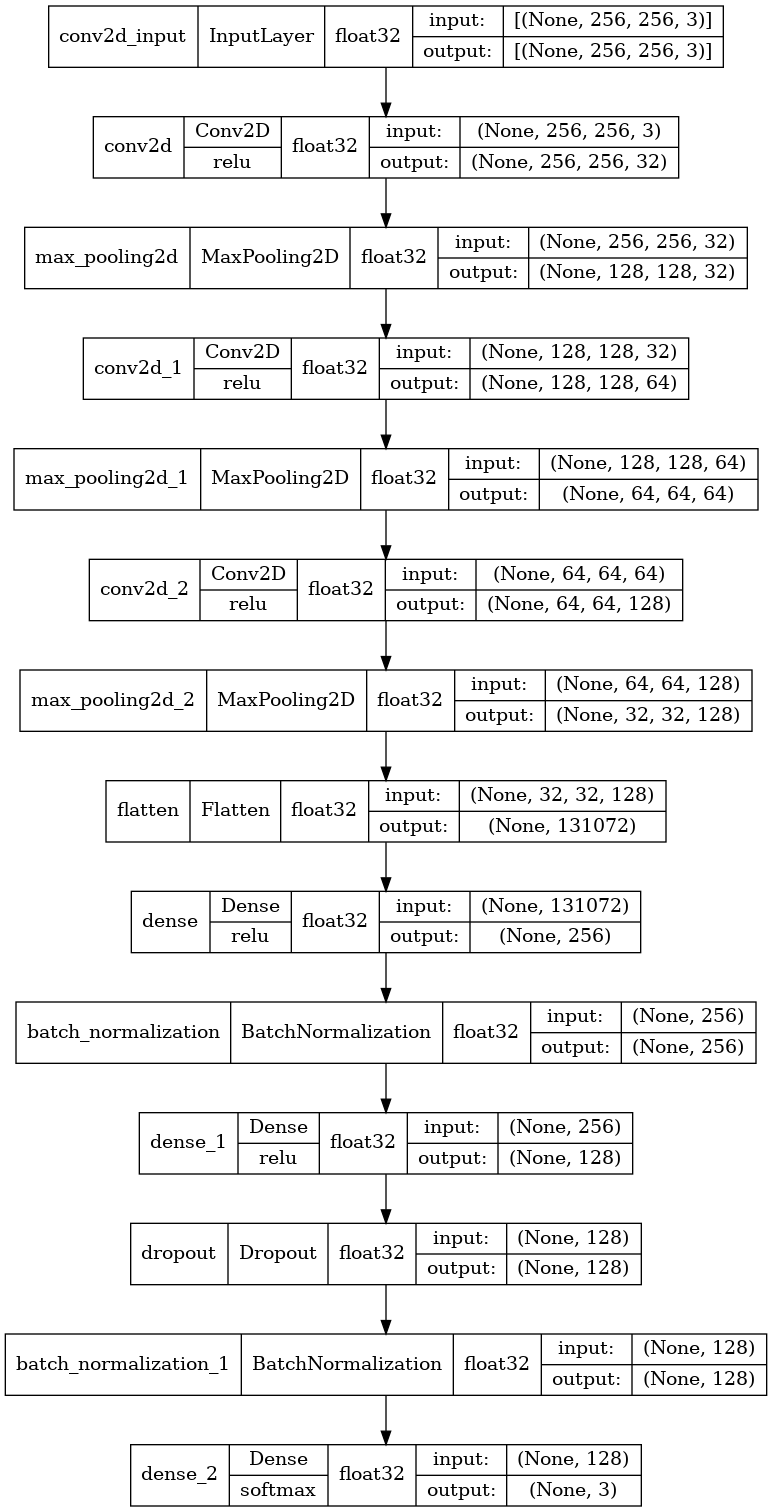

In [14]:

keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [15]:

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [17]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

2023-08-15 15:22:52.411311: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2359296000 exceeds 10% of free system memory.
2023-08-15 15:22:54.906947: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2359296000 exceeds 10% of free system memory.


Epoch 1/10


2023-08-15 15:22:57.000077: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-08-15 15:22:58.467985: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-15 15:22:58.471473: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-15 15:22:58.472194: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-15 15:22:58.473716: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-15 15:22:58.473764: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-08-15 15:22:58.965978: W tensorflow/core/common_runtime/bf

188/188 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8608

2023-08-15 15:23:25.971865: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 589824000 exceeds 10% of free system memory.
2023-08-15 15:23:26.587814: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 589824000 exceeds 10% of free system memory.
2023-08-15 15:23:29.223724: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


188/188 [==============================] - 36s 157ms/step - loss: 0.3444 - accuracy: 0.8608 - val_loss: 4.9485 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 25s 133ms/step - loss: 0.2097 - accuracy: 0.9148 - val_loss: 0.8700 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 25s 134ms/step - loss: 0.1740 - accuracy: 0.9317 - val_loss: 0.8986 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9452
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 25s 133ms/step - loss: 0.1401 - accuracy: 0.9452 - val_loss: 1.1219 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 25s 133ms/step - loss: 0.0866 - accuracy: 0.9692 - val_loss: 1.8002 - val_accuracy: 0.6007 - lr: 5.0000e-04


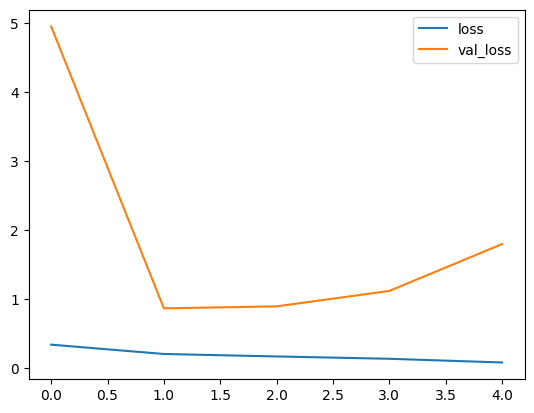

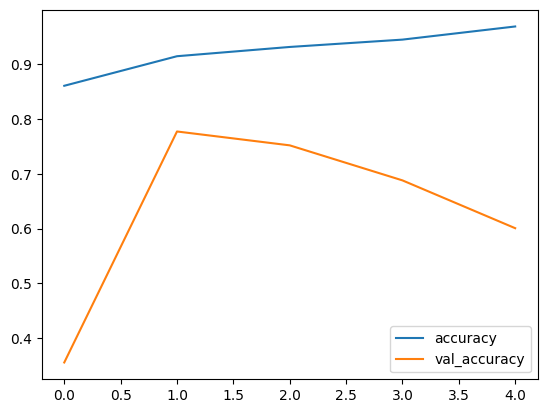

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [19]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

2023-08-15 15:25:39.615859: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 589824000 exceeds 10% of free system memory.


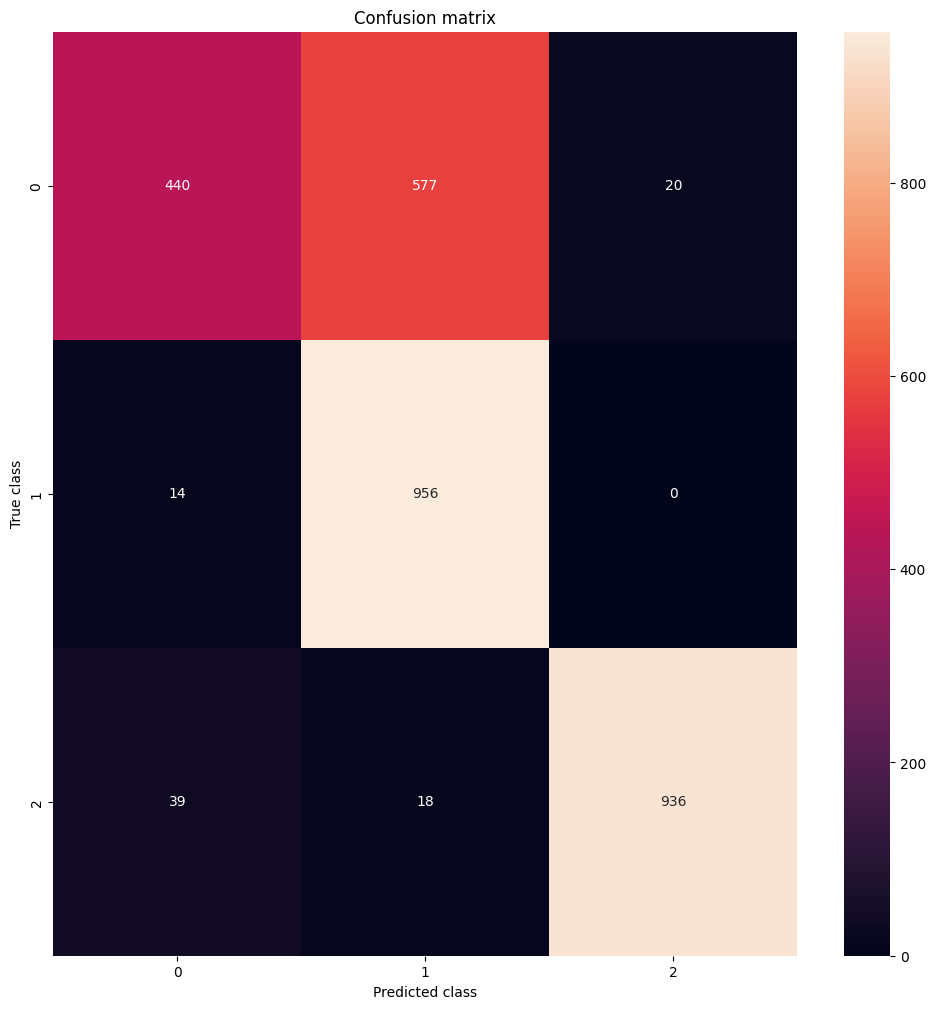

In [22]:
cm = metrics.confusion_matrix(Y_val, Y_pred)

import seaborn as sns

plt.figure(figsize =(12, 12))
sns.heatmap(cm,annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [21]:

print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.89      0.42      0.58      1037
    lung_scc       0.62      0.99      0.76       970
      lung_n       0.98      0.94      0.96       993

    accuracy                           0.78      3000
   macro avg       0.83      0.78      0.76      3000
weighted avg       0.83      0.78      0.76      3000

